In [7]:
library(tidyverse)
library(lubridate)
library(cowplot)
library(yardstick)
library(DBI)
library(SCCS)
library(gnm)
library(broom)
library(rsample)
library(ggplot2)
library(ggpubr)
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 400)

## Get data

In [3]:
con1 <- DBI::dbConnect(
    RMySQL::MySQL(), 
    host = "localhost",
    user = "uog2000",
    port = 3307,
    dbname = "user_uog2000",
    password = read_file('/home/uog2000/mimir_setup/password.txt') %>% str_replace('\n', '')
)

In [4]:
ref_ades <- con1 %>% tbl('reference_ades') %>% as_tibble

In [5]:
main_data <- con1 %>% tbl('sccs_psm_score_ade') %>% as_tibble %>%
                        replace_na(list(events = 0, history = 0)) %>%
                        group_by(person_id, drug_concept_id, cohort_id) %>%
                        filter(max(events) > 0) %>%  # cases only
                        group_by(person_id) %>%
                        filter(max(events) <= 78) %>% ungroup() %>%  # 0.99 percentile
                        group_by(drug_concept_id, cohort_id) %>%
                        filter(n_distinct(person_id) >= 10) %>%  # minimum of 10 people
                        ungroup() %>%
                        mutate(person_id = factor(person_id),
                        norm_age = (age_at_start - min(age_at_start))/(max(age_at_start)-min(age_at_start)))

In [6]:
main_data %>% colnames()

[1] "drug_concept_id"  "person_id"        "start"            "end"             
 [5] "cohort_id"        "duration"         "risk"             "age_at_start"    
 [9] "propensity_score" "condition_name"   "drug_name"        "affect"          
[13] "events"           "history"          "norm_age"

## SCCS analysis + bootstrap

Conditional poisson model w/ and w/o utilization score (propensity score in code) and 1000 bootstraps

In [6]:
set.seed(100)
results_1 <- main_data %>%
    mutate(person_id = factor(person_id)) %>%
    nest(data = -c(drug_concept_id, cohort_id)) %>%
    mutate(
        wopsm = data %>%
                   map(~gnm(formula = events ~ risk + history + age_at_start,
                            eliminate = person_id, offset = log(duration),
                            family = 'poisson', data = .)) %>%
                   map(broom::tidy),
        wpsm = data %>%
                   map(~gnm(formula = events ~ risk + history + age_at_start + propensity_score,
                            eliminate = person_id, offset = log(duration),
                            family = 'poisson', data = .)) %>%
                   map(broom::tidy)
        
    ) %>%
    pivot_longer(cols = ends_with('psm'), names_to = 'models', values_to = 'results') %>%
    unnest(results) %>%
    select(-data)
results_1 %>% head

drug_concept_id,cohort_id,models,term,estimate,std.error,statistic,p.value
<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1334456,500000301,wopsm,risk,0.74178344,0.047078401,15.756343,6.212516e-56
1334456,500000301,wopsm,history,-0.07383639,0.003247901,-22.733570,2.086594e-114
1334456,500000301,wopsm,age_at_start,0.13209415,0.010789544,12.242792,1.836051e-34
1334456,500000301,wpsm,risk,-0.65473232,0.065812670,-9.948424,2.562094e-23
1334456,500000301,wpsm,history,-0.05003276,0.003112423,-16.075180,3.808852e-58
1334456,500000301,wpsm,age_at_start,0.04354573,0.011434119,3.808403,1.398672e-04


In [7]:
set.seed(100)
aurocs <- results_1 %>%
            filter(term == 'risk') %>%
            inner_join(ref_ades, by = c('drug_concept_id', 'cohort_id')) %>%
            mutate(affect_factor = factor(affect, levels = c(1,0), ordered = T)) %>%
            bootstraps(times = 1000, strata = cohort_id) %>%
            rowwise() %>%
            mutate(auroc = splits %>% as_tibble() %>%
                            group_by(models, condition_name) %>% 
                            roc_auc(affect_factor, estimate) %>% 
                            select(condition_name, models, auroc = `.estimate`) %>% list) %>% 
            unnest(auroc) %>% select(-splits)

In [ ]:
neg_control_metrics <- 
    results_1 %>%
    inner_join(ref_ades, by = c('drug_concept_id', 'cohort_id')) %>%
    filter(term == 'risk', affect == 0) %>%
    bootstraps(times = 1000, strata = cohort_id) %>%
    rowwise() %>%
    mutate(results = splits %>% as_tibble %>%
               mutate(rr = exp(estimate),
                       CI_upper = exp(estimate + (1.96* std.error)),
                       CI_lower = exp(estimate - (1.96* std.error)),
                       log_rr = log(rr),
                       log_upper = log(CI_upper),
                       log_lower = log(CI_lower),
                       bias = (log_rr - 0),
                       mse = (log_rr - 0)^2,
                       coverage = ((log_upper > 0) & (log_lower < 0)) %>% as.integer) %>% ## log risk ratio is 0
                group_by(models, condition_name) %>% 
                summarise(
                    n = n(),
                    bias = mean(bias),
                    mse = mean(mse),
                    coverage = sum(coverage)/n
                ) %>% list
           ) %>% unnest(results) %>%
    select(-splits)

In [15]:
neg_control_metrics %>%
    inner_join(aurocs, by = c('id', 'models', 'condition_name')) %>%
    pivot_longer(bias:auroc, names_to = 'measure', values_to = 'val') %>%
    mutate(measure = recode(measure,
                            auroc = 'AUROC',
                            bias = 'Bias',
                            coverage = 'Coverage',
                            mse = 'MSE')) %>% head

id,models,condition_name,n,measure,val
<chr>,<chr>,<chr>,<int>,<chr>,<dbl>
Bootstrap0001,wopsm,Acute kidney injury,37,Bias,1.0406908
Bootstrap0001,wopsm,Acute kidney injury,37,MSE,2.0103269
Bootstrap0001,wopsm,Acute kidney injury,37,Coverage,0.1351351
Bootstrap0001,wopsm,Acute kidney injury,37,AUROC,0.6846405
Bootstrap0001,wopsm,Acute liver injury,25,Bias,0.8672083
Bootstrap0001,wopsm,Acute liver injury,25,MSE,0.9274132


In [18]:
neg_control_metrics %>%
    inner_join(aurocs, by = c('id', 'models', 'condition_name')) %>%
    pivot_longer(bias:auroc, names_to = 'measure', values_to = 'val') %>%
    mutate(measure = recode(measure,
                            auroc = 'AUROC',
                            bias = 'Bias',
                            coverage = 'Coverage',
                            mse = 'MSE')) %>%
write_csv('performance_mimir.csv')

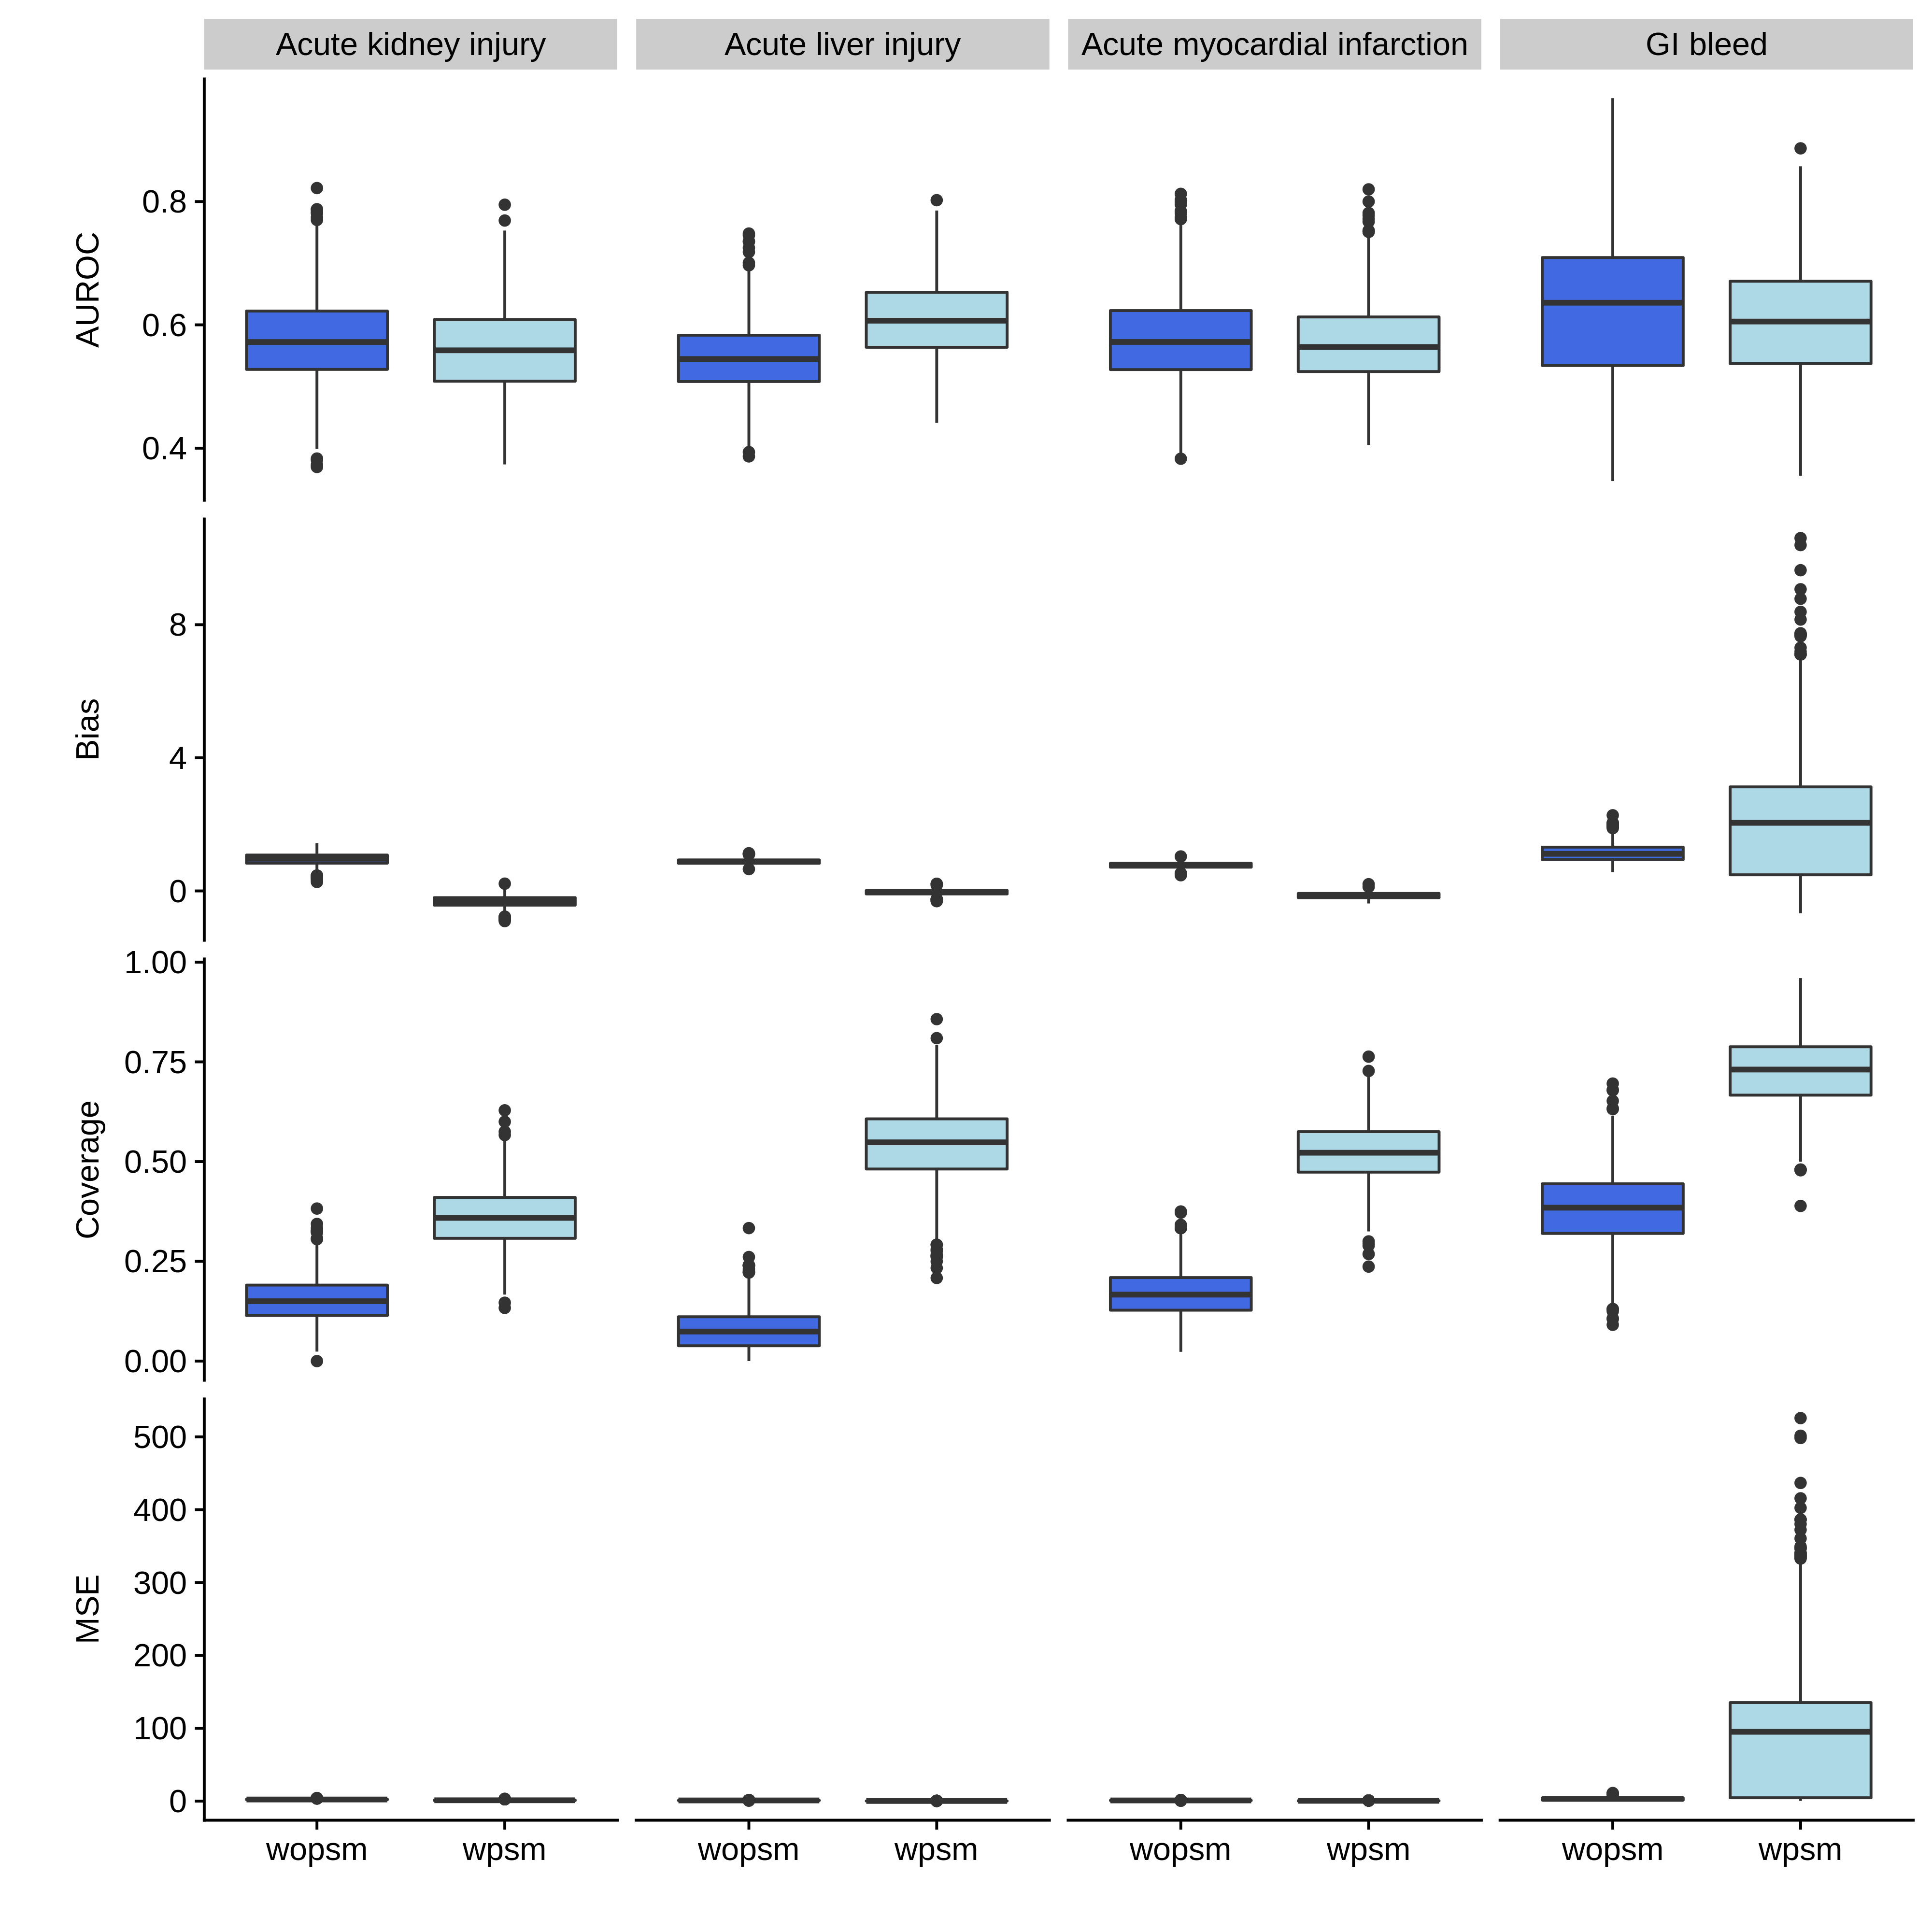

In [17]:
p_result <- neg_control_metrics %>%
    inner_join(aurocs, by = c('id', 'models', 'condition_name')) %>%
    pivot_longer(bias:auroc, names_to = 'measure', values_to = 'val') %>%
    mutate(measure = recode(measure,
                            auroc = 'AUROC',
                            bias = 'Bias',
                            coverage = 'Coverage',
                            mse = 'MSE')) %>%
ggplot(mapping = aes(x = models, y = val, fill = models)) +
  geom_boxplot() +
  facet_grid(rows = vars(measure),
             cols = vars(condition_name),
             scales = 'free',
             margins = 'am',
             switch = 'y') +
  xlab('') + ylab('') +
  theme_cowplot() +
  theme(legend.position = '',
        strip.placement = 'outside',
        strip.background.y = element_rect(fill = NA)) +
  scale_fill_manual(values = c('royalblue', 'lightblue'))

p_result